In [1]:
from belief import GroupSkillBelief
from belief import plot_beliefs
import numpy as np
from matplotlib import pyplot as plt

In [2]:
class Group():
    def __init__(self, skills) -> None:
        self.users = self.generate_users(skills)

    def generate_users(self, skills):
        users = {}
        num_users = 2
        for i in range(num_users):
            users[i] = User(i, skills)
        return users
    
    def work_on_skill(self, t, skill):
        contributions = {}
        masteries = {}
        observed = 0
        for uid in self.users:
            contributed_prob, mastered = self.users[uid].contribute_to_skill(t, skill)
            contributed = np.random.choice([0, 1], p=[1 - contributed_prob, contributed_prob])
            if contributed == 1:
                observed = 1
            contributions[uid] = contributed
            masteries[uid] = mastered
        return contributions, masteries, observed
    
    def teach_skill(self, t, skill):
        total_mastery = 0
        for uid in self.users:
            total_mastery += self.users[uid].skill_masteries[skill.sid]
        for uid in self.users:
            self.users[uid].teach_skill(t, skill, total_mastery, len(self.users))

class User():
    def __init__(self, uid, skills) -> None:
        self.uid = uid
        self.skill_masteries = self.generate_masteries(skills)

    def generate_masteries(self, skills):
        skill_masteries = {}
        for sid in skills:
            mastered = np.random.randint(2)
            skill_masteries[sid] = mastered
        return skill_masteries
    
    def contribute_to_skill(self, t, skill):
        mastered = self.skill_masteries[skill.sid]
        contributes = mastered * (1 - skill.prob_slip) + (1 - mastered) * skill.prob_guess
        
        attempted = self.skill_attempted(t, skill)
        
        return contributes * attempted, mastered
    
    def teach_skill(self, t, skill, total_mastery, num_users):
        if num_users > 1:
            attempted = self.skill_attempted(t, skill)
            mastered = self.skill_masteries[skill.sid]
            if mastered: #and (total_mastery - 1) == 0:
                unteach_prob = skill.prob_unlearn * attempted * (1 - (total_mastery - 1) / (num_users - 1))
                self.skill_masteries[skill.sid] = np.random.choice([0, 1], p=[unteach_prob, 1 - unteach_prob])
            elif not mastered:# and ((total_mastery) / (num_users - 1)) == 1:
                teach_prob = skill.prob_learn * attempted * (total_mastery / (num_users - 1))
                self.skill_masteries[skill.sid] = np.random.choice([0, 1], p=[1 - teach_prob, teach_prob])
        

    def skill_attempted(self, t, skill):
        if t <= (skill.discuss_time + skill.solve_time):
            attempted = t / (skill.discuss_time + skill.solve_time)
        else:
            attempted = 1
        return attempted


class Skill():
    def __init__(self, sid) -> None:
        self.sid = sid
        self.prob_slip = np.random.uniform(low = 0.1, high = 0.25)
        self.prob_guess = np.random.uniform(low = 0.1, high = 0.25)
        self.prob_learn = np.random.uniform(low = 0.0, high = 0.0) #low = 0.1, high = 0.25
        self.prob_unlearn = np.random.uniform(low = 0.0, high = 0.0) #low = 0.1, high = 0.25
        
        self.discuss_time = np.random.randint(low = 80, high = 150)
        self.solve_time = np.random.randint(low = 50, high = 100)

class Task():
    def __init__(self) -> None:
        self.task_time = 300
        self.skills = self.generate_skills()
    
    def generate_skills(self):
        skills = {}
        num_skills = np.random.randint(low = 5, high = 10) #5, 10
        for i in range(num_skills):
            skills[i] = Skill(i)
        return skills

class Round():
    def __init__(self) -> None:
        self.task = Task()
        self.group = Group(self.task.skills)

        self.t = 0
        self.time_steps = []
    
    def complete(self):
        for i in range(self.task.task_time):
            self.step()


    def step(self):
        self.time_steps.append(self.work())
        self.teach()
        self.t += 1
    
    def teach(self):
        for sid in self.task.skills:
            self.group.teach_skill(self.t, self.task.skills[sid])

    def work(self):
        time_step = {}
        for sid in self.task.skills:
            time_step[sid] = self.group.work_on_skill(self.t, self.task.skills[sid])
        return time_step

In [3]:
class Trial():
    def __init__(self) -> None:
        self.round = Round()
        self.beliefs = {}

        for sid in self.round.task.skills:
            uids = self.round.group.users.keys()
            p_L_0s = {}
            for uid in uids:
                p_L_0s[uid] = 0.5
            skill = self.round.task.skills[sid]
            skill_belief = GroupSkillBelief(sname="Skill", 
                                            sid=sid, 
                                            uids=uids, 
                                            p_L_0s=p_L_0s, 
                                            p_S=skill.prob_slip, 
                                            p_G=skill.prob_guess, 
                                            p_T=skill.prob_learn,
                                            n=10, 
                                            discussion_time=skill.discuss_time, 
                                            solve_time=skill.solve_time)
            self.beliefs[sid] = skill_belief

    def complete(self):
        for i in range(self.round.task.task_time):
            
            self.round.step()

            if i == 0:
                continue

            for sid in self.round.task.skills:
                c_ts = {}
                skill = self.round.time_steps[self.round.t - 1][sid]
                for uid in self.round.group.users:
                    c_ts[uid] = skill[0][uid]
                o_t = skill[2]
                self.beliefs[sid].step(o_t, c_ts)  


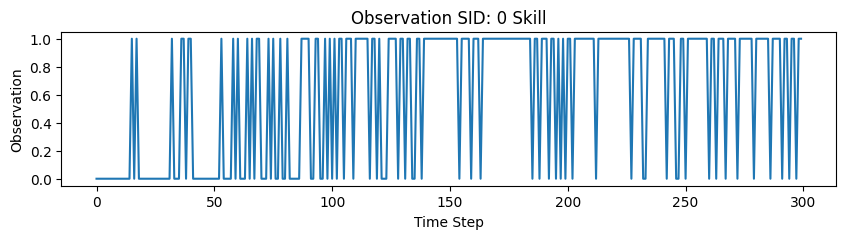

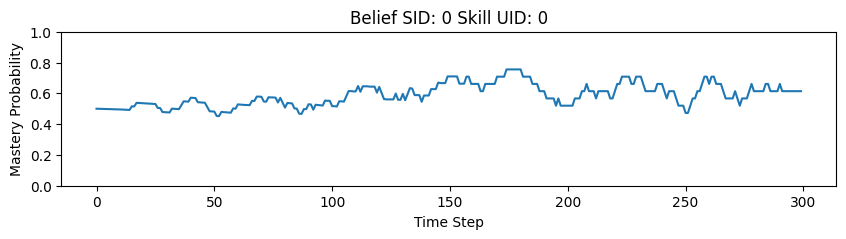

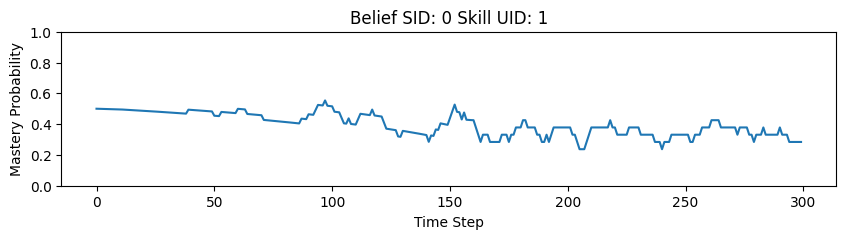

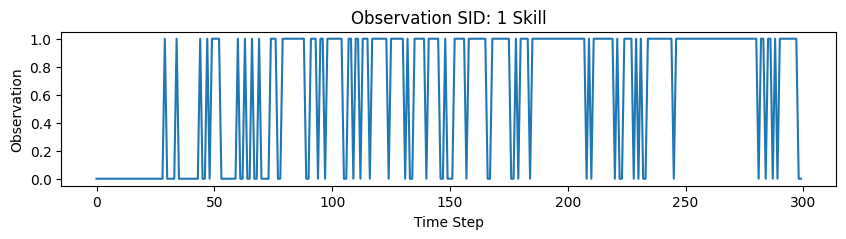

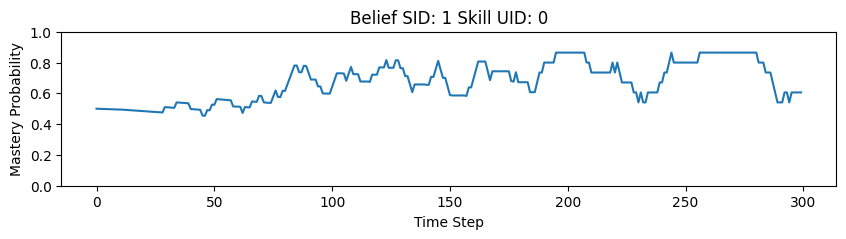

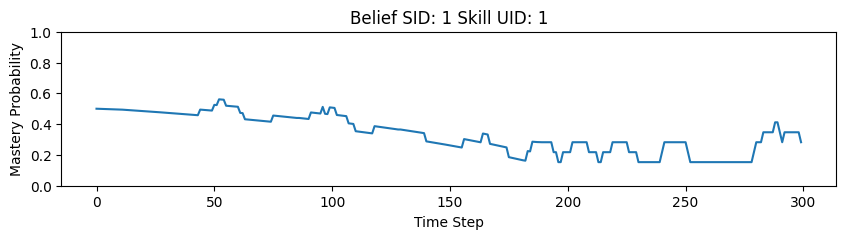

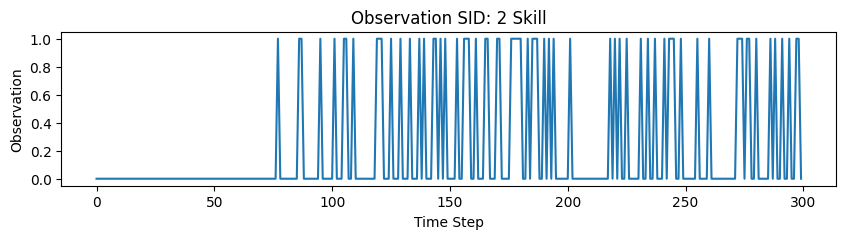

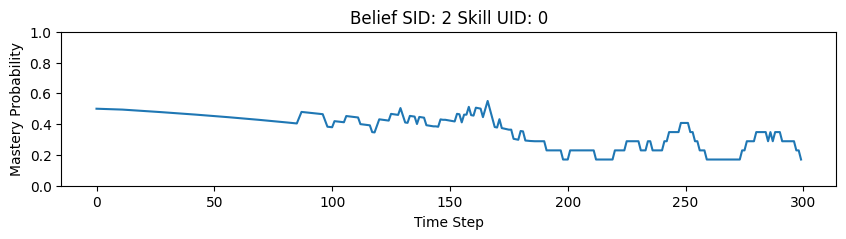

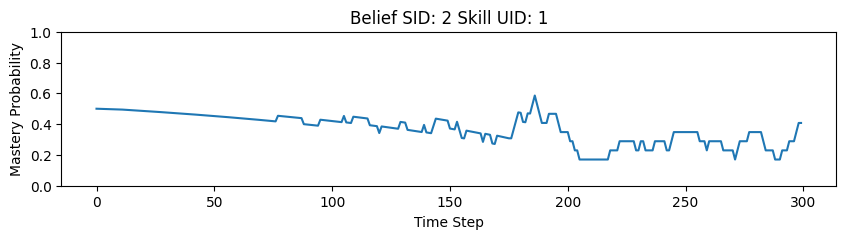

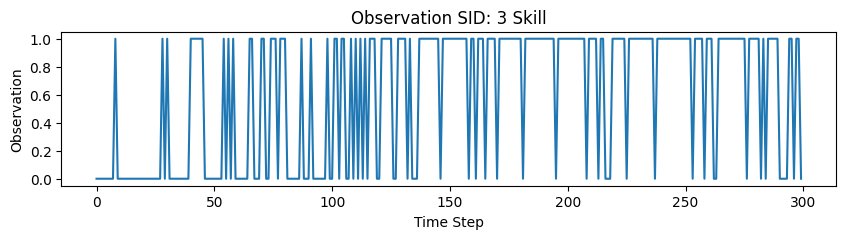

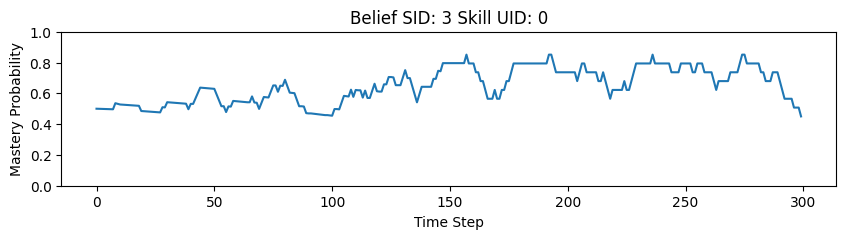

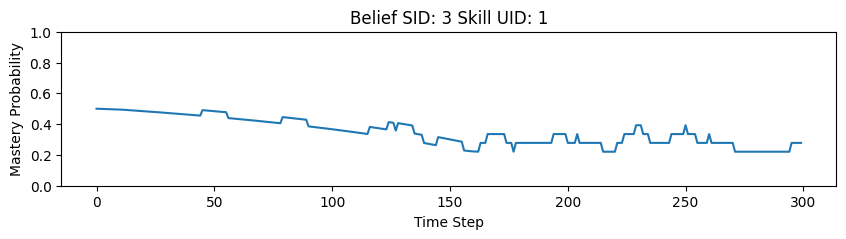

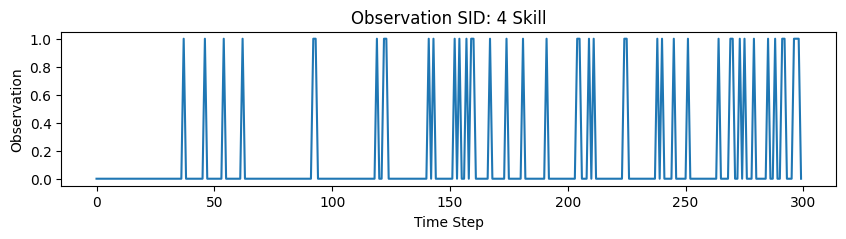

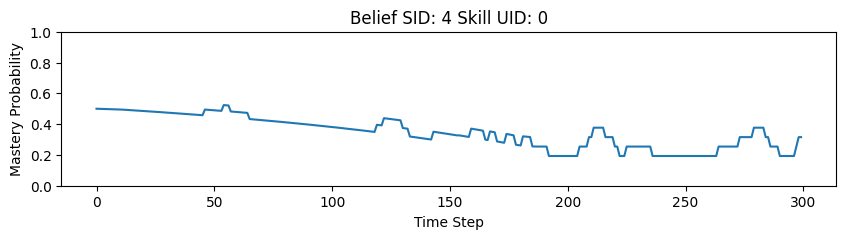

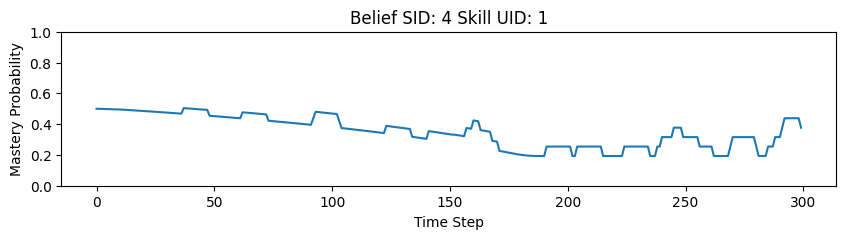

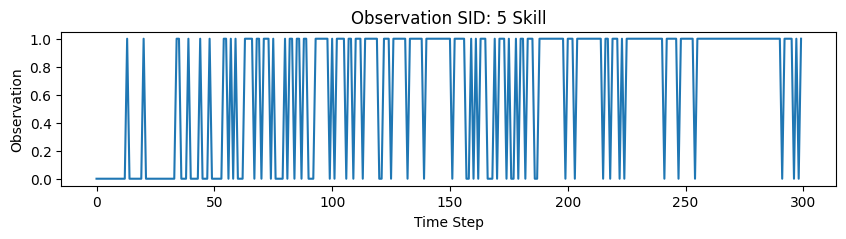

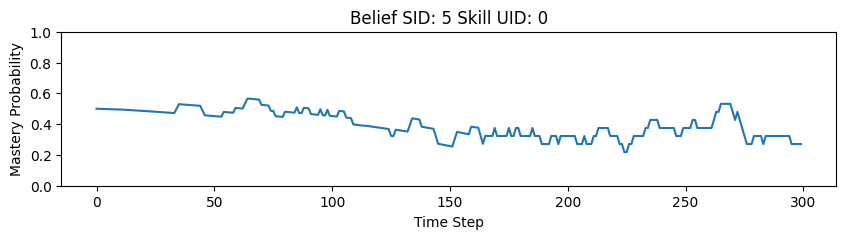

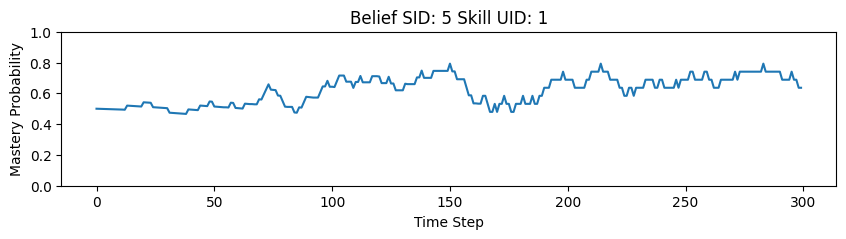

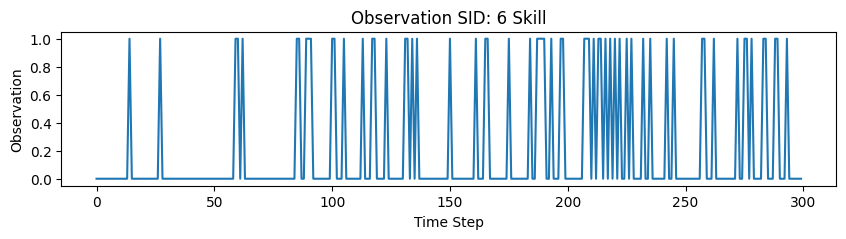

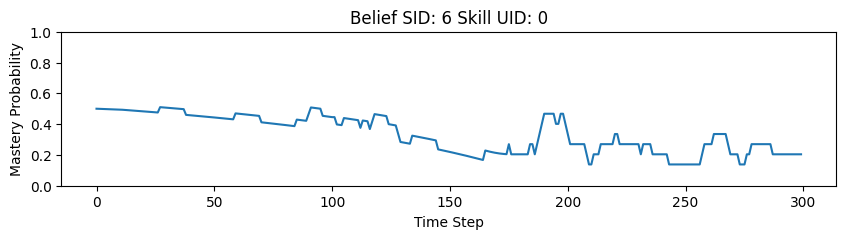

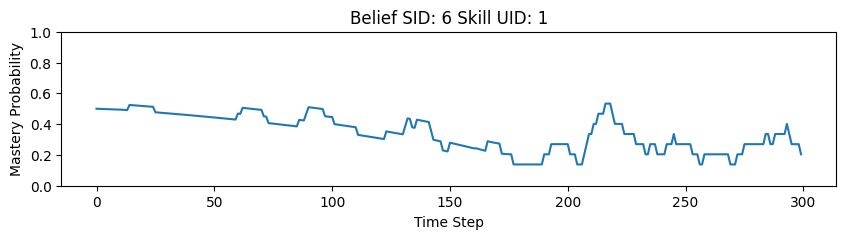

In [4]:
trial = Trial()
trial.complete()
plot_beliefs(trial.beliefs)

In [5]:
# round = Round()
# print(round.time_steps)
# round.complete()
# print(round.time_steps)

# plot_observation(round)